In [1]:
using Plots
using JLD
using StatsPlots
using LaTeXStrings
using Statistics

include("../src/FCSeqTools.jl");
include("../src/functions.jl");

# SELECT DATA ############################################################################
alignment = "CM_alignment"  #"Betalactamases"  #    
sigla = "(CM)"    #"(BL)"  #                                           
method = "cumulative"
test = "main_test"
stop = 0.9
fraction = 0.3
alphas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]#, 0.95]
l = length(alphas)
notebooks = [1, 2, 3]
#########################################################################################
q = 21
sigla == "(CM)"  ? L = 96  : L = 222
#########################################################################################

rm(joinpath("figures/"* alignment * "/complexity_vs_pseudo-count"), force=true, recursive=true)
mkdir(joinpath("figures/"* alignment * "/complexity_vs_pseudo-count"))
path = joinpath("figures/"* alignment * "/complexity_vs_pseudo-count");

## Complexity vs Pseudo Count

In [2]:
edges, elements, iterations = zeros(l), zeros(l), zeros(l)
mom2_edges, mom2_elements = zeros(l), zeros(l)
σ_edges, σ_elements = zeros(l), zeros(l)
idx = 0
for α ∈ alphas
    idx += 1
    for nbk ∈ notebooks
        folder = "../training/" * alignment * "/" * method * "/" * test * "/"
        path_α_nbk = folder *method*string(fraction)*"_stop="*string(stop)*"_reg="*string(α)*"_nb"*string(nbk)
        data = parse.(Float64, split(readlines(open(path_α_nbk * "/iterations.txt", "r"))[end], " ")[1:end-1])
        iterations[idx] += data[1]
        edges[idx] += data[6] 
        elements[idx] += data[7]
        mom2_edges[idx] += data[6] * data[6] 
        mom2_elements[idx] += data[7] * data[7]
    end 
    edges[idx] /= 3
    elements[idx] /= 3
    mom2_edges[idx] /= 3
    mom2_elements[idx] /= 3
end
σ_edges = sqrt.(mom2_edges .- edges .* edges)
σ_elements = sqrt.(mom2_elements .- elements .* elements)

Nij_tot = L * (L - 1) /2
Nij_ab_tot = Nij_tot * q^2;

In [3]:
plot(alphas, elements./Nij_ab_tot*100, yerr=σ_edges./Nij_ab_tot*100, xlabel="pseudo-count "*L"(\alpha)", ylabel="%", marker=:circle, title= sigla*" Element Complexity vs pseudo-count", label=:false)
savefig(joinpath(path,"element_complexity_vs_pseudo-count.png"));

In [4]:
plot(alphas, elements./edges,  xlabel="pseudo-count "*L"(\alpha)", ylabel="numero di elementi per edge", marker=:circle, title=sigla*" Edge Complexity vs pseudo-count", label=:false)
savefig(joinpath(path,"edge_complexity_vs_pseudo-count.png"));

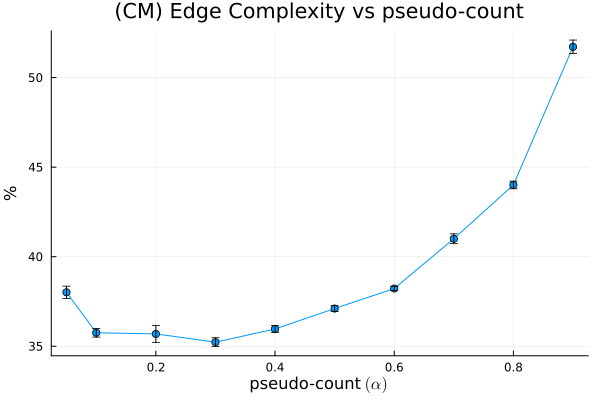

In [5]:
plot(alphas, edges ./ Nij_tot * 100, yerr=σ_edges./Nij_tot*100, xlabel="pseudo-count "*L"(\alpha)", ylabel="%", marker=:circle, title=sigla*" Edge Complexity vs pseudo-count", label=:false)


## Robustness of the learning vs pseudo-count

In [6]:
comm_elements, comm_edges = zeros(l), zeros(l)
tot_edges, tot_elements = zeros(l), zeros(l)
mom2_comm_edges, mom2_comm_elements = zeros(l), zeros(l)
σ_comm_edges, σ_comm_elements = zeros(l), zeros(l)

idx = 0
for α in alphas
    println(α)
    idx += 1
    folder = "../training/" * alignment * "/" * method * "/" * test * "/"
    path_α_nb1 = folder * method * string(fraction) * "_stop=" * string(stop) * "_reg=" * string(α) * "_nb" * string(1)
    path_α_nb2 = folder * method * string(fraction) * "_stop=" * string(stop) * "_reg=" * string(α) * "_nb" * string(2)
    path_α_nb3 = folder * method * string(fraction) * "_stop=" * string(stop) * "_reg=" * string(α) * "_nb" * string(3)
    file_path1 = joinpath(path_α_nb1, "example_output.txt");
    file_path2 = joinpath(path_α_nb2, "example_output.txt");
    file_path3 = joinpath(path_α_nb3, "example_output.txt");
    edges1, elements1, scores1 = read_example_output(file_path1)
    edges2, elements2, scores2 = read_example_output(file_path2)
    edges3, elements3, scores3 = read_example_output(file_path3)

    n_edges12, n_elements12, n_edges_x12, n_edges_y12, n_elements_x12, n_elements_y12 = compare_edges(edges1, elements1, edges2, elements2, L);
    n_edges13, n_elements13, n_edges_x13, n_edges_y13, n_elements_x13, n_elements_y13 = compare_edges(edges1, elements1, edges3, elements3, L);
    n_edges23, n_elements23, n_edges_x23, n_edges_y23, n_elements_x23, n_elements_y23 = compare_edges(edges2, elements2, edges3, elements3, L);

    comm_edges[idx] = (n_edges12[end] + n_edges13[end] + n_edges23[end]) / 3
    comm_elements[idx] = (n_elements12[end] + n_elements13[end] + n_elements23[end]) / 3
    mom2_comm_edges[idx] = (n_edges12[end]*n_edges12[end] + n_edges13[end]*n_edges13[end] + n_edges23[end]*n_edges23[end]) / 3
    mom2_comm_elements[idx] = (n_elements12[end]*n_elements12[end] + n_elements13[end]*n_elements13[end] + n_elements23[end]*n_elements23[end]) / 3

    tot_edges[idx] = (n_edges_x12[end] + n_edges_x13[end] + n_edges_x23[end] + n_edges_y12[end] + n_edges_y13[end] + n_edges_y23[end]) / 6
    tot_elements[idx] = (n_elements_x12[end] + n_elements_x13[end] + n_elements_x23[end] + n_elements_y12[end] + n_elements_y13[end] + n_elements_y23[end]) / 6
  
end
σ_comm_edges = sqrt.(mom2_comm_edges .- comm_edges .* comm_edges)
σ_comm_elements = sqrt.(mom2_comm_elements .- comm_elements .* comm_elements);

0.05
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [7]:
plot(alphas, comm_edges./tot_edges*100, yerr=σ_comm_edges./tot_edges*100, xlabel="pseudo-count "*L"(\alpha)", ylabel="%", marker=:circle, title= sigla*" Common Edges vs pseudo-count", label=:false)
savefig(joinpath(path,"common_edges_vs_pseudo-count.png"));


In [8]:
plot(alphas, comm_elements./tot_elements*100, yerr=σ_comm_edges./tot_elements*100, xlabel="pseudo-count "*L"(\alpha)", ylabel="%", marker=:circle, title= sigla*" Common Elements vs pseudo-count", label=:false)
savefig(joinpath(path,"common_elements_vs_pseudo-count.png"));

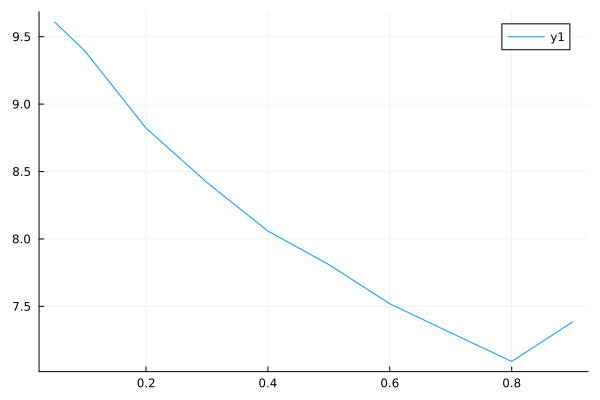

In [9]:
plot(alphas, comm_elements./comm_edges)